# SC42150 - Python assignment 2

Adaptive Noise Cancellation Applied to RF Communication



## Team members

Name (student number): Danny Looman (4573269)

Name (student number): Bas van Vliet (4594959)

## Introduction

This application follows the theory from Chapter 9. The goal of adaptive noise
cancellation is to remove interference from a signal of interest by means of a
correlated noise reference signal. In this example, we consider an RF communication system consisting of an
emitter and a receiver. These systems experience noise at the receiver that causes
signal degradation. The interference originates from the thermal noise of the system
and from the RF environment. The receiver measures signals of interest
on the main channel and reference noise on a secondary channel. Since both
channels have different propagation delays and distortions, the noise signals are
distinct. However, the unwanted noise in the primary port and the reference
noise are highly correlated. Therefore, it is possible to design a linear FIR filter
that produces an estimate of the interference from the primary channel. We wish
to use the theory of Wiener filters to recover the underlying audio signal.

## Reporting


The report of this python exercise consists of a PDF version of this Jupyter Notebook file, with your answers added after each question. Answers will consist of code and/or text (markdown) cells.
In order to create a PDF version of this file, go to the top left, click on `File` then `Download As` and Choose **PDF**.
If this feature is not supported by your system, you can also choose **LaTeX**.
Then, you can use your preferred **LaTeX** compiler to create the **PDF**. After generation you PDF report, please double check if all answers/plots are correctly displayed.

Moreover, you will also need to send the .mat file with the signals used in this exercise. Don't forget to edit your team member's name and student number above. You will submit one Jupyter notebook per team.

## First steps

Make sure that the files `Audio.py`, `Communication.py` and `anc.jpg` are included in the same directory as this Jupyter notebook. Run the following code:

In [2]:
if 0:
    ! pip install pyserial
    ! pip install sounddevice
    ! pip install scipy

**Note:** You only need to execute this code snippet once, after that your python will permanently include the modules. If the the code gives an error, manually install the modules using pip in the command prompt. In Windows: start button->search, type cmd->`pip install package_name`

## Question 1
Follow the instructions bellow in order to transmit/receive the signals that will be used in this assignment.

### Signal transmission

- Place a 32-bit .wav file in the same folder as this jupyter notebook (you can use the `piano.wav` or `gong.wav` files provided). Fill in the filename in the function `Audio.read_audiofile('filename.wav',length_seconds)` to load the audio;
- Set a desired duration for the transfer. It is recommended to start with signal lengths of one second to three, since serial transmission is a slow protocol;
- Connect the transceiver to a USB port. If the device is functioning properly, when instantiating the `Communication.Comm()` object you will get the following message: `Device recognized`;
- For signal transmission to take place, the receiving computer must be "listening" for signals. Make sure that the **receiver code snippet is running before executing sending**. When signal transmission starts, you will get a `started` message;
- It is suggested to start with short distances between the transmitter and the receiver, shorter than 1 meter. This will keep the SNR at acceptable levels.

### Signal acquisition

- There are two channels on the antenna of the dongles. The first listens for signals. The second channel measures adjacent noise from the environment which is correlated with the noise in the main channel. When you call `receiver.receive()`, you get two return values: the first one measures the signal from the emitters and the second measures a brown noise signal;
- When the signal is received, the program will display the message `done`.

### Receive Signal: run on receiving PC

In [3]:
import Audio
import Communication
import numpy as np

if 0:
    receiver = Communication.Comm()
    audio_sig, channelNoise_sig = receiver.receive()

### Send signal: run on sending PC

**Note**: Execute after the paired PC has executed the receiving code

In [4]:
# Load modules
import Communication
import Audio
if 0:
    # Instantiate communication object
    transmit = Communication.Comm()

    # Load audio
    length_seconds = 5
    datasend = Audio.read_audiofile('gong.wav',length_seconds)

    # Send
    transmit.write(datasend)

**Troubleshooting:** if you have problems transmitting the signal, try disconnecting **both** devices and connecting them again. The ports may be overflowed with data after long periods of time or there may be a poor connection. If the problem persists, also try restarting the Jupyter notebook's kernel.

### Play the signal
Go to this section after you **received** a signal.
Play the audio, can you hear the signal through the noise? If you can't hear it at all, try to reduce the distance between the transmitter and receiver devices.

In [5]:
import sounddevice as sd

# function for playing a signal
# You can use it further if you want to listen smth

def play_signal( signal ):
    sd.play( signal.astype('int16'), 22050 )

### Saving the signal with the noise as a .mat file
Run this section after you received and played a signal.
It will save the audio signals as a .mat file. With this file, you no longer need the RF comminication hardware to proceed with this assignment. Note that this is the .mat file you will need to hand-in together with the Jupyter notebook with your answers.

In [6]:
if 0:
    # saving the signals in .mat file
    import scipy.io as sciio

    sciio.savemat('audio_data.mat', mdict = {
        'audio' : audio_sig,
        'noise': channelNoise_sig,
    })

    print( f'number of points = {audio_sig.shape}' )

### Load the .mat file

In [7]:
# packages
import numpy as np
import scipy.io as sio

# load the data file
data = sio.loadmat('Piano40cm.mat')  # contains data, (print to see)

y = data['audio'][0]
v2 = data['noise'][0]

y = y.astype(float)
v2 = v2.astype(float)

# constants
N = len( data['audio'][0] ) # number of data points per signal
x = np.arange( 0, N )  # point indices
print( f'\nN = {N}' )

#play_signal(data['audio'][0])


N = 109217


### Display signal and noise source

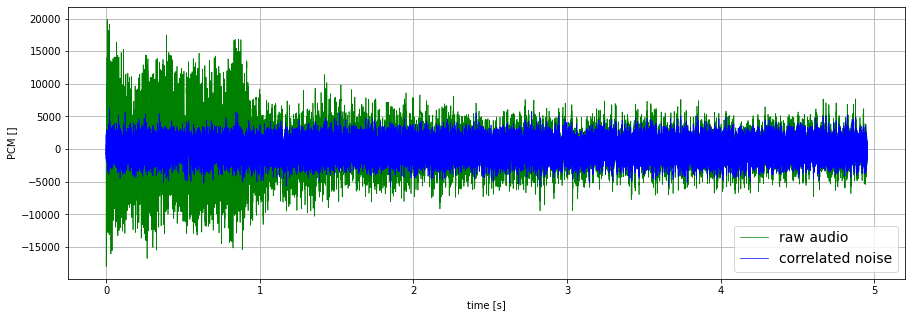

In [8]:
import matplotlib.pyplot as plt
t = np.arange(0.,  np.size(y)/22050, 1/22050)
plt.figure(figsize=(15, 5))
plt.plot(t,y,'g', linewidth=0.7, label='raw audio')
plt.plot(t,v2,'b', linewidth=0.7, label='correlated noise')
plt.ylabel('PCM []')
plt.xlabel('time [s]')
plt.legend(loc='lower right', prop={'size': 14})
plt.grid(True)

## Question 2

Formulate the problem as a Minimum Variance FIR Wiener Problem, using the symbols $v_1, \ v_2, \ y, \ \hat{v}_1, \ d,$ and $e$ as in the figure below. No numerical values are required in this part. It is sufficient to connect the theory to the practice by explaining the meaning of all the symbols and their relation to the two measured signals: *audio_sig* and *channelNoise_sig*. Also explain how to finally recover the interference-free audio signal when the Wiener problem has been solved. **(3 points)**

![alt text][anc]

[anc]: ./anc.JPG

### Answer 2

The following relations are present between the variables $v_1, \ v_2, \ y, \ \hat{v}_1, \ d,$ and $e$

$y(n) = d(n) + v_1(n)$

- $y$ is the audio signal: Audio_sig
- $d$ is the desired signal
- $v_1$ is the noise on the audio signal

$\hat v_1 = W^Hv_2$

- $\hat v_1$ is the noise estimator of $v_1$ using the noise measurement $v_2$ and the transfer function $W^H$
- $v_2$ is the noise measurement: channelNoise_sig

$e(n) = v_1(n) - \hat v_1$

- $e$ is the error between $v_1$ and $\hat v_1$

The interference-free audio signal can be recovered (partially restored or improved) by
substracting the noise estimator $\hat v_1$ from the audio signal $y$. For a good estimator $\hat v_1$,
the audio signal becomes:

$y(n) = d(n) + v_1(n) - \hat v_1(n) \approx d(n) $

## Question 3
Determine the Wiener-Hopf equation for this problem, and explain how the different terms in the equation relate to the two measured signals. What assumptions do we use here to obtain the values of the filter $w$? **(2 points)**

### Answer 3

Question 3
Assumptions that are used (p. 174-175 of the lecture notes):

- (1) $d(n)$ and $v_2(n)$ are uncorrelated and stoichastic processes,
such that the cross-correlation $r_{dv2} = E[d(n)v_2^*(n - k)] = 0$ for all k
Under this assumption, the cross-correlation $r_{v_1v_2}(k)$ is also equal to the cross-correlation $r_{yv_2}(k)$:
$r_{yv_2}(k) = E[y(n)v_2^*(n - k)] =  E[d(n)v_2^*(n - k)] + E[v_1(n)v_2^*(n - k)] = E[v_1(n)v_2^*(n - k)] = r_{v_1v_2}(k)$

- (2) $v_1$ and $v_2$ are zero-mean WSS
- (3) $v_2(n)$ and $y(n)$ can both be measured
- (4) The realization of the stochastic processes $v_2(n)$ and $y(n)$ is finite
and the coefficients of the auto- and cross-correlation can be estimated under the assumption of ergodicity


Equation (9.21) from the lecture notes is the Wiener Hopf equation,
which is used for solving the FIR active noise cancellation problem.
This equation indicates that the cross-correlation $r_{yv_2}(k)$ and the auto-correlation $r_{v2}(k)$ are needed to find an estimate of the Wiener filter coefficients $\hat \omega(k)$.

$r_{yv_2}(k) = E[y(n)v_2^*(n - k)]$

$r_{v2}(k) = E[v_2(n)v_2^*(n - k)]$

$\hat \omega = R_{v2}^{-1}r_{yv2}$

where
- $R_{v2}$ is a matrix

# ik weet niet zeker of \omega een estimate is, want omdat het een finite signal is heb je wel toegang tot alle data

## Question 4

If only the measured signals are given, the auto- and cross-correlations used in the Wiener-Hopf equation need to be approximated. This can be done using the following formula:

$$\hat{r}_{v_2}(\tau) = \frac{1}{N-\tau}\sum_{n=\tau + 1}^N v_2(n) v_2(n-\tau),  \quad \hat{r}_{v_1 v_2}(\tau) = \frac{1}{N-\tau}\sum_{n=\tau+1}^N v_1(n) v_2(n-\tau).$$

Calculate the approximations of the auto- and cross-correlations using the measured signals.
Provide the used code and print the first $10$ values of the auto- and cross-correlations ($\tau = 0, 1, \ldots, 9$). **(3 points)**

### Answer 4

_Insert the cells with your answer below._

In [9]:
def correlation(x1:np.ndarray,x2:np.ndarray,max_lag:int)->np.ndarray:
    """
    determines correlaiton between vectors x1, and x2. if x1 and x2 are the same
    the auto correlation will be computed. X1 and X2 must have the same length.
    assumption is made that the vectors are real valued. So no conjugation is necessary.
    :param x1: input vector 1
    :param x2: input vector 2
    :param max_lag: number of time shifts calculated
    :return: vector of size max_lag which contains the corresponding correlation
    """
    if np.size(x1) != np.size(x2): # validate input
        print("Not the same size vectors")
        return np.array(0)

    _N = np.size(x1)
    _out = np.zeros(max_lag)

    for _l in range(max_lag):
        _temp_x1 = x1[_l+1 : _N]
        _temp_x2 = x2[0 : _N-_l-1]
        _out[_l] = 1/(_N - _l) * np.dot(_temp_x1, _temp_x2)

    return _out

tau = 30 # filter order
r_v2 = correlation(x1=v2, x2=v2, max_lag=tau)
r_yv2 = correlation(x1=y, x2=v2, max_lag=tau)

## Question 5

Using a 10-th order FIR Wiener filter, calculate the optimal filter coefficients. Provide the used code and print the 10 filter coeficients. *Hint: the `scipy.linalg.toeplitz` function may be useful for defining the covariance matrix*. **(3 points)**

### Answer 5

_Insert the cells with your answer below._

In [10]:
import scipy

def get_w_hat(auto_corr, cross_corr):
    _R_mat = scipy.linalg.toeplitz(auto_corr)
    return np.matmul(np.linalg.inv(_R_mat),cross_corr)

w_hat = get_w_hat(r_v2, r_yv2)

print(w_hat)

[1.27816329 0.05708551 0.06015503 0.06164093 0.05023286 0.06983196
 0.03936477 0.05418027 0.04330469 0.04039858 0.04810274 0.04390766
 0.03198251 0.03168134 0.04875192 0.03546854 0.03017647 0.03253231
 0.02237268 0.03511979 0.02443902 0.01477102 0.03849906 0.00914832
 0.02721348 0.02761554 0.0092826  0.02540095 0.01601504 0.10841361]


## Question 6

We can now use the filter $w_{opt}$ to obtain our estimate of the noiseless audio signal.
Calculate the recovered audio signal using the optimal Wiener filter.
Plot both the measured noise and the recovered noiseless audio signal. 
*Hint: the function `scipy.signal.lfilter` can be useful when using the Wiener filter*. **(3 points)**

### Answer 6
_Insert the cells with your answer below._

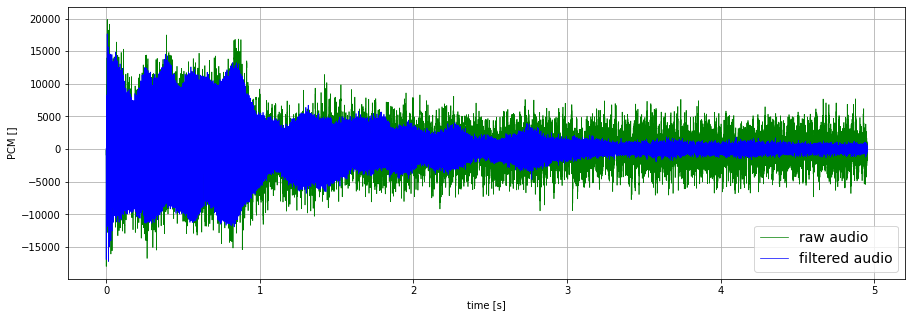

In [11]:
from scipy import signal

def get_d_hat(filter_coeff, target, noise_signal):
    _v1_hat = signal.lfilter(b=filter_coeff, a=1, x=noise_signal)
    return np.subtract(target, _v1_hat)

d_hat = get_d_hat(w_hat, y, v2)

play_signal(d_hat)

# plot new figure
plt.figure(figsize=(15, 5))
plt.plot(t,y,'g', linewidth=0.7, label='raw audio')
plt.plot(t,d_hat,'b', linewidth=0.7, label='filtered audio')
plt.ylabel('PCM []')
plt.xlabel('time [s]')
plt.legend(loc='lower right', prop={'size': 14})
plt.grid(True)

## Question 7
To investigate the effect of the filter order on the estimate of the audio bitstream, we will vary the filter order between $m= 2$ and $m= 20$. In you experiments, what is the minimum order necessary to remove the environmental noise? In other words, around what number does an increase in filter order no longer yield a significant improvement?  Justify your answer. **(3 points)**

### Answer 7

_Insert the cells with your answer below._

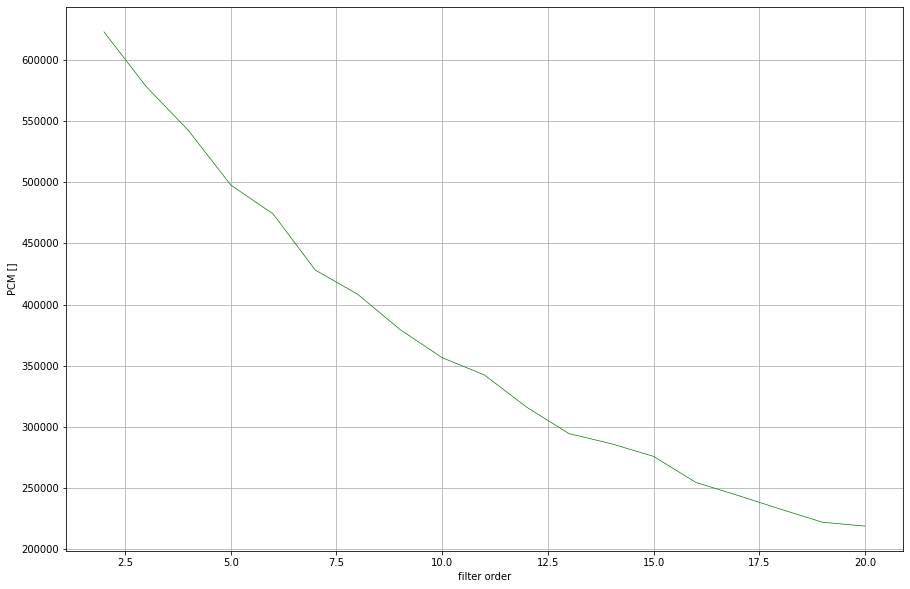

In [12]:
new_d_mat = np.zeros((19,N))
var_last_sec = np.zeros(19)

for m in range(2,21):
    r_v2 = correlation(x1=v2, x2=v2, max_lag=m)
    r_yv2 = correlation(x1=y, x2=v2, max_lag=m)

    # assume last second is zero mean
    current_d_hat = get_d_hat(get_w_hat(r_v2, r_yv2), y, v2)
    var_last_sec[m-2] = sum(current_d_hat[N-22050:N]**2)/22050
    new_d_mat[m-2,:] = current_d_hat


filter_order = np.arange(2,21)

# plot new figure
plt.figure(figsize=(15, 10))
plt.plot(filter_order,var_last_sec,'g', linewidth=0.7, label='variance last second')
plt.ylabel('PCM []')
plt.xlabel('filter order')
plt.grid(True)

In [13]:
# possibility to play the signal with different filter orders
play_signal(new_d_mat[20-2,:])